# Lab 6 - Ensembles

Members: Preston Tighe, Arturo Laguna

## Preparation
The dataset is a collection of handwritten digits taken from American Census Bureau employees. The data was collected by the National Institute of Science and Technology (NIST) and is a subset of their training data. It comes from a larger database called the Mixed National Institute of Science and Technology (MNIST) database. It is split into two datasets, training and testing. The dataset used in this project is a subset of size 60,000 images that are each 28x28 pixels.

The data can be found and downloaded from:
http://yann.lecun.com/exdb/mnist/

Our task is to determine a digit (0-9) from a handwritten image of a specific digit.

The classification task is the following:
Given an array of feature vectors and a target vector (10 classes: the numbers 0-9) containing the information described below, create a TLP that can correctly predict the target (10 classes: the numbers 0-9) given a feature vector.

This data is important because the classification of written digits can be useful. To list a couple of examples: reading credit cards, standardized test grading, written text to digital text conversion and more.

Our prediction algorithm would need to be greater than 85% $F_1$ score to be somewhat considered useful by interested parties. Although, 95% would be ideal, 85% would be decent enough to be used in production for some applications.

In [1]:
import sys
import warnings
import gzip

import numpy as np

from scipy import interp

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

from multiprocessing import Pool, cpu_count
from struct import unpack

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, roc_curve, auc, f1_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.validation import check_X_y, check_array
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize

%matplotlib inline
%reload_ext  memory_profiler
plt.style.use('ggplot')

In [2]:
# Parse dataset, only use 5,000 images

binaryData = gzip.open('train-images-idx3-ubyte.gz', 'rb')
binaryLabels = gzip.open('train-labels-idx1-ubyte.gz', 'rb')

# Get metadata for images
# magic number means nothing to me so skip
binaryData.read(4)
binaryLabels.read(8)
numImages = binaryData.read(4)
numImages = unpack('>I', numImages)[0]
numImages = numImages - 55000
# Interpret packed binary data as '>I' which is big endian unsigned int
numRows = binaryData.read(4)
numRows = unpack('>I', numRows)[0]
numCols = binaryData.read(4)
numCols = unpack('>I', numCols)[0]

print(numImages) # should be 5000

# Now read into numpy array
images = np.empty([numImages, numRows, numCols], dtype=np.float32) 
Y = np.empty([numImages,], dtype=np.uint8)
for image in range(numImages):
    for row in range(numRows):
        for col in range(numCols):
                pixel = binaryData.read(1)  # Just a single byte
                pixel = unpack('>B', pixel)[0]
                images[image][row][col] = pixel
    label = binaryLabels.read(1)
    Y[image] = unpack('>B', label)[0]
print('done')

5000
done


In [3]:
# Bag of pixels model

X = np.empty([numImages, numRows * numCols])
for i in range(numImages):
    X[i] = images[i].flatten()

In [4]:
# Initial dataset description

n_samples, n_features = X.shape
_, h, w = images.shape
n_classes = len(Y)
classes = np.unique(Y)

print("Original n_samples: {}".format(n_samples))
print("Original n_features: {}".format(n_features))
print("Original n_classes: {}".format(len(classes)))
print("Original n_class_labels: {}".format(n_classes))
print("Original image sizes: {} by {}".format(h,w))

Original n_samples: 5000
Original n_features: 784
Original n_classes: 10
Original n_class_labels: 5000
Original image sizes: 28 by 28


In [5]:
# Full PCA with 95% variance from Lab 3 graph by choosing the top 150 components
# Full PCA was the best of full, kernel, and randomized PCA

pca = PCA(n_components=150)
X = pca.fit_transform(X)
n_samples, n_features = X.shape
print("New n_samples: {}".format(n_samples))
print("New n_features: {}".format(n_features))
print('Total images in each class: ' + str(np.bincount(Y)))

New n_samples: 5000
New n_features: 150
Total images in each class: [479 563 488 493 535 434 501 550 462 495]


Our final dataset $X$ is a table of 5000 images that have been flattened and dimensionally reduced using Full PCA to their top 150 eigenobjects using only 150 columns instead of 784 different columns that was initially based on the 28x28 size (height x width = 784).

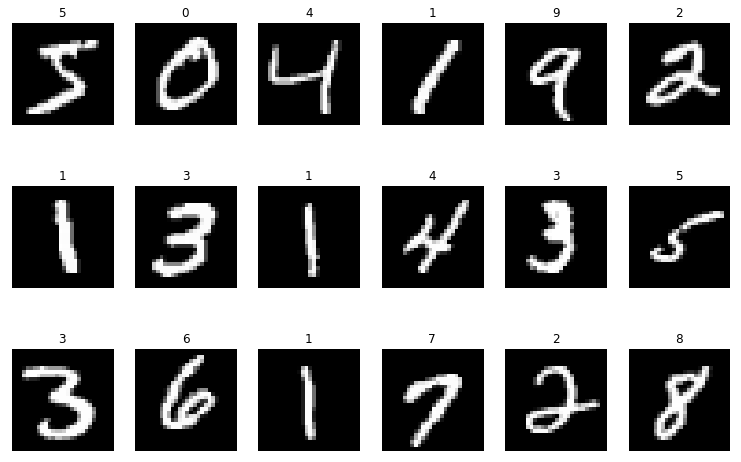

In [6]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(images, Y, h, w)
plt.show() # need for python 3

## Evaluation

### Metrics

We need to choose a method for scoring our classifier based on recall, precision, accuracy and $F_1$ score. There can only be 4 types of classification when classifying an image. They are true positive ($tp$), true negative ($tn$), false positive ($fp$) and false negative ($fn$).

We just need to maximize the true positives ($tp$) or the true negatives ($tn$). Accuracy does not take into account false positives ($fp$) so we need a metric that does this for us. We also want to minimize both false positives ($fp$) and false negatives ($fn$). The $F_1$ score does all of this for us with the formula <br/> <br/> $$(1) \qquad F_1 = \frac{2 (rp)}{(r + p)}$$ <br/> The $F_1$ score is the harmonic mean ($H$) using precision ($p$) and recall ($r$) <br/> <br/> $$p = \frac{tp}{tp+fp} \qquad r = \frac{tp}{tp+fn}$$ <br/> We use the harmonic mean ($H$) here because we are dealing with ratios when we are finding the probability.


### Dividing Data Methods

We also needed to choose a method for splitting our data set into even smaller sets that more closely resemble a real-life scenario. Reasoning being we don't get to train every sample of data that comes in before needing to predict what its outcome will be. We have a couple of tools to use for our training-test model selection: basic percent based train-test, K-folds, shuffle splits and stratified K-fold. We know that our set is pretty much balanced at ~500 samples for each class and there should not be any bias in the ordering of members of a class. We could reliably pick any of the model selection techniques and still get decent results. However, some of the techniques are significantly better than the others. We want one of the stratified techniques as there is no reason we should introduce a class imbalance into the mix when there was none before. We also want to actually use a cross-validation technique rather than a simple test-train split, as it helps us to try out every data sample in a training set. Accordingly, this leaves us with either stratified K-Fold splits or stratified shuffle splits. Randomly selecting *x* members of each class should not introduce any bias and using a shuffle split has the potential to be faster. Our final cross-validation technique will be Stratified Shuffle Split.

## Modeling

Our model is an ensemble made up of a number of mlp scikit-learn classifiers. Our ensemble classifier chooses data for each classifier randomly using the bagging technique. Each internal classifier uses replacement as an option so records can be duplicated from one internal classifier to the next. Every single internal classifier is weighted based on a f1 score when initially fitting the data. When the classifier is predicting, it can decide between a majority or majority probabilistic vote. 

Majority probabilistic voting takes into account the f1_score of each classifier combined with the actualy predict_proba value. Majority vote prediction predicts from every internal classifier and sums up the f1_scores of each classifier, the class with the highest summed f1_scores is the predicted class.

Our custom ensemble implementation is also capable of distributed computing with multiple cores when fitting to the data.

In [7]:
# Have to import this to run GridSearchCV - CustomBaggingClassifier found relative to this IPython notebook

from CustomBaggingClassifier import CustomBaggingClassifier
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)

### Ensemble Parameter Tuning

We decided to use GridSearchCV to determine the best parameters for our custom bagging ensemble classifier. After a couple of tweaks including having to import the custom classifier to get multiple threads working, changing the job count to 8, and lowering the estimator counts, we were able to run 24 scenarios in 10 minutes.

In [11]:
from sklearn.model_selection import GridSearchCV

params = dict(
    clf__n_estimators = [10,15,20] ,
    clf__replacement = (True, False),
    clf__weighted = (True,False),
    clf__proba_voting = [True, False]
)

pl = Pipeline([('scaler', StandardScaler()), ('clf', CustomBaggingClassifier())])
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
gs = GridSearchCV(pl, params, n_jobs=8, scoring='f1_macro', cv=cv, verbose=10)
gs.fit(X, Y)
print('Best F1 score: ' + str(gs.best_score_))
print('Best params: ' + str(gs.best_params_ ))

Fitting 1 folds for each of 24 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done  12 out of  24 | elapsed:  7.1min remaining:  7.1min
[Parallel(n_jobs=8)]: Done  15 out of  24 | elapsed:  8.9min remaining:  5.3min
[Parallel(n_jobs=8)]: Done  18 out of  24 | elapsed:  9.6min remaining:  3.2min
[Parallel(n_jobs=8)]: Done  21 out of  24 | elapsed: 12.3min remaining:  1.8min
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed: 12.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed: 12.5min finished


Best F1 score: 0.924945394885
Best params: {'clf__n_estimators': 15, 'clf__proba_voting': True, 'clf__replacement': True, 'clf__weighted': True}


In [8]:
# Testing the model with 1 classifier

params =  dict(
    n_estimators = 1,
    replacement = True,
    weighted = True,
    proba_voting = True,
    print_progress = True
)

pl = Pipeline([('scaler', StandardScaler()), ('clf', CustomBaggingClassifier(**params))])
for train_index, test_index in cv.split(X, Y):
    %time %memit pl.fit(X[train_index], Y[train_index])
    yhat = pl.predict(X[test_index])
    print('f1 score:', f1_score(Y[test_index], yhat, average='macro'))
    print('How many of each class did we predict? ' + str(np.bincount(yhat)))

peak memory: 173.96 MiB, increment: 18.55 MiB
Wall time: 6.58 s
f1 score: 0.896727733645
How many of each class did we predict? [ 94 120  79  91 118  95 104 113  87  99]


In [9]:
# Testing the model with 20 classifiers

params =  dict(
    n_estimators = 20,
    replacement = True,
    weighted = True,
    proba_voting = True,
    print_progress = True
)

pl = Pipeline([('scaler', StandardScaler()), ('clf', CustomBaggingClassifier(**params))])
for train_index, test_index in cv.split(X, Y):
    %time %memit pl.fit(X[train_index], Y[train_index])
    yhat = pl.predict(X[test_index])
    print('f1 score:', f1_score(Y[test_index], yhat, average='macro'))
    print('How many of each class did we predict? ' + str(np.bincount(yhat)))

peak memory: 186.83 MiB, increment: 25.56 MiB
Wall time: 56.6 s
f1 score: 0.905309029698
How many of each class did we predict? [101 114  98  98 115  83 100 112  84  95]


In [10]:
# Trying out classifier using a bigger amount of estimators to test the multiple jobs effenciency using 8 cores (100 classifiers).

params =  dict(
    n_estimators = 100,
    replacement = True,
    weighted = True,
    proba_voting = True,
    print_progress = True,
    n_jobs = 8
)

pl = Pipeline([('scaler', StandardScaler()), ('clf', CustomBaggingClassifier(**params))])
for train_index, test_index in cv.split(X, Y):
    %time %memit pl.fit(X[train_index], Y[train_index])
    yhat = pl.predict(X[test_index])
    print('f1 score:', f1_score(Y[test_index], yhat, average='macro'))
    print('How many of each class did we predict? ' + str(np.bincount(yhat)))

peak memory: 214.08 MiB, increment: 45.98 MiB
Wall time: 4min 42s
f1 score: 0.90132912006
How many of each class did we predict? [ 99 117  94  89 116  96 102 111  80  96]


### Confusion Matrix

The confusion matrix for our 100 estimators is shown below. The numbers 7, 2, and 5 had the most amount of false positives from highest to lowest.

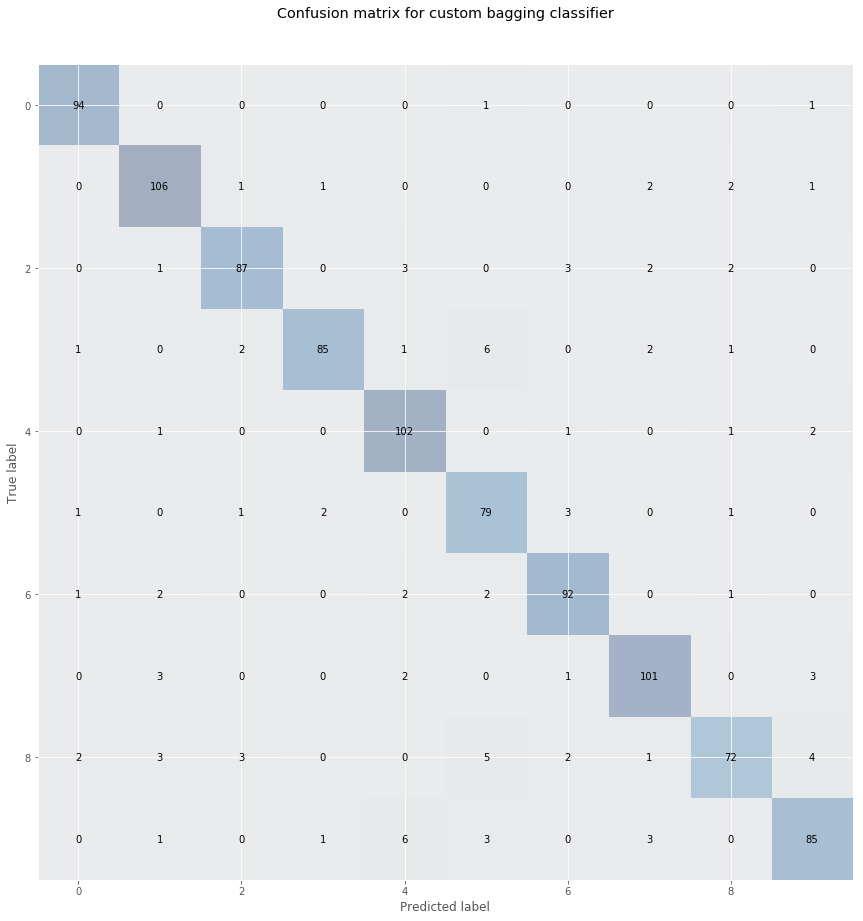

In [12]:
cf_mat = confusion_matrix(Y[test_index], yhat)
fig, ax = plot_confusion_matrix(conf_mat=cf_mat, figsize=(15,15))
plt.title('Confusion matrix for custom bagging classifier')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### F1 score per class

To get a better feel for the f1 score for each class we plotted it below. Just like lab 3, we realized the classifiers don't have problems with the number 1 (almost 98% f1 score).

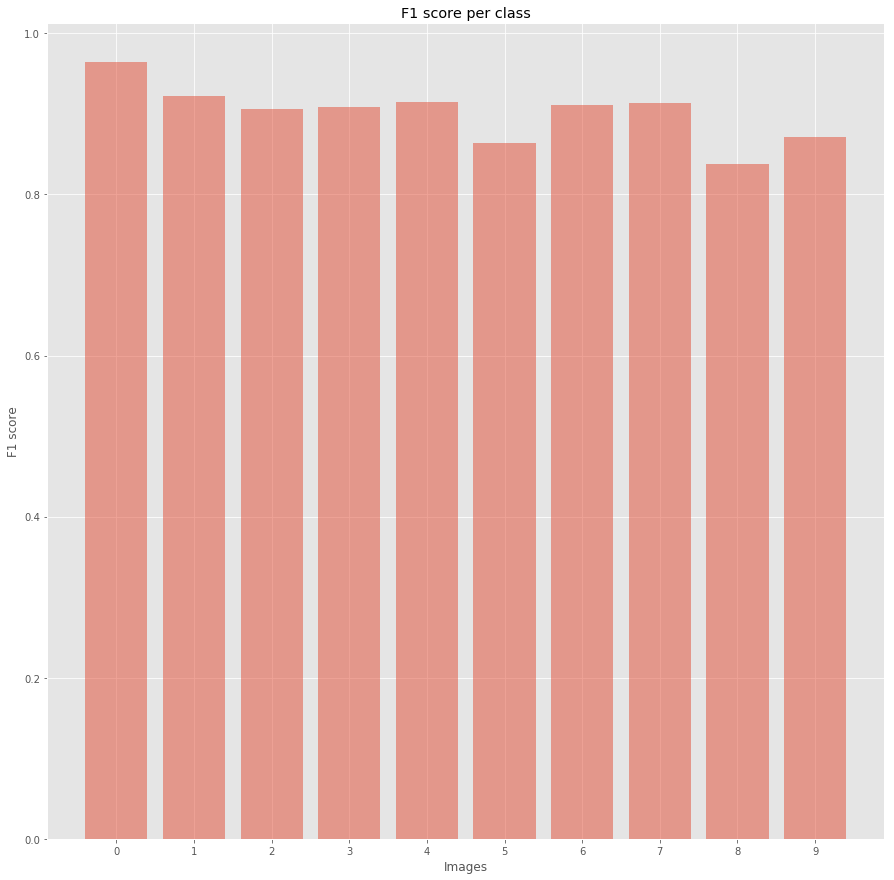

In [13]:
f1_scores = [f1_score(Y[test_index], yhat, average='macro', labels=[j]) for j in classes]
    
plt.figure(figsize=(15,15))

plt.bar(classes, f1_scores, align='center', alpha=0.5)
plt.xticks(classes)

plt.xlabel("Images")
plt.ylabel("F1 score")

plt.title("F1 score per class")
plt.show()

### Receiver Operating Characteristics

Instead of plotting every classifier, we just plotted the ROC & AUC of the final classifier classes, the worst internal classifier, and the best internal classifier. The internal and the output classifiers all have a similar area around the .96-.99 range which is really good. The ROC's are almost ideal. The most ideal situation would be 1 true positive and 0 false positive which is in the top left hand of the graphs (a graph from 0,0 -> 0,1 -> 1,1). Most of the ROC's bow towards the top left. The similarity between the underlying classifiers and the whole ensembles classifier shows that with bagging there is going to be a slight change in the f1 score which was discovered when modeling 1 classifier vs. 100 classifiers.

In [26]:
worst_classifier_index = np.argmin(pl.named_steps['clf'].precisions_)
best_classifier_index = np.argmax(pl.named_steps['clf'].precisions_)
print('Worst classifier index: ' + str(worst_classifier_index))
print('Best classifier index: ' + str(best_classifier_index))

Worst classifier index: 26
Best classifier index: 10


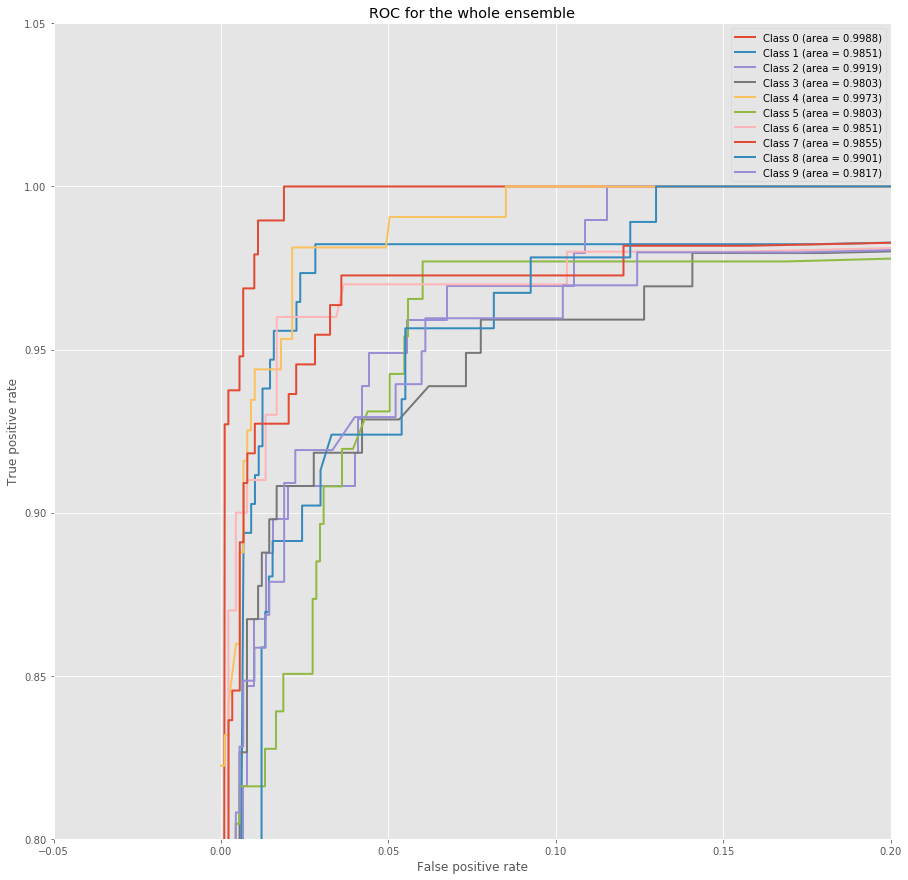

In [28]:
# Visualizing roc & auc for the whole ensemble

plt.figure(figsize=(15,15))

for i in classes:
    fpr, tpr, _ = roc_curve(Y[test_index],
                        pl.named_steps['clf'].predict_proba(X[test_index])[:, i],
                        pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, '-', lw=2, label='Class %s (area = %0.4f)'
               % (i, roc_auc)) 

plt.legend(loc='best')
plt.xlim([-.05, .2])
plt.ylim([0.8, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC for the whole ensemble')

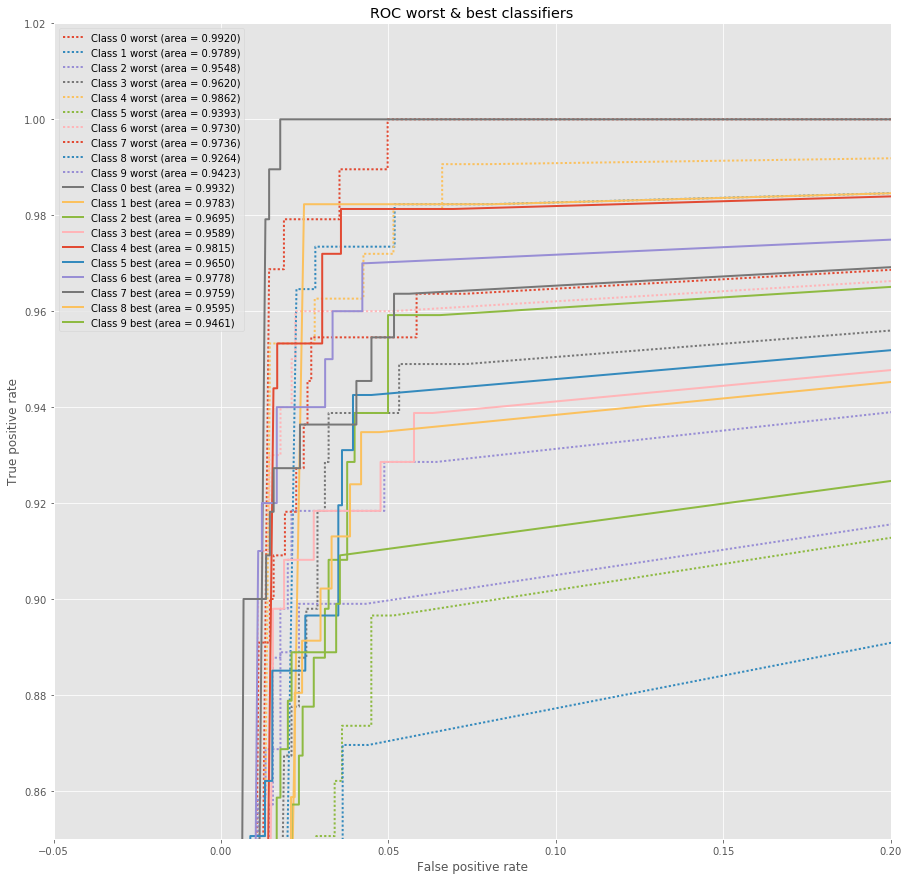

In [29]:
# Visualizing roc & auc for worst & best classifiers

plt.figure(figsize=(15,15))

for classifier_index in [worst_classifier_index, best_classifier_index]:
    for class_index in classes:
        
        is_worst = classifier_index == worst_classifier_index
        fpr, tpr, _ = roc_curve(Y[test_index],
                        pl.named_steps['clf'].predict_single_classifier_proba(X[test_index],classifier_index)[:, class_index],
                        pos_label=class_index)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, ':' if is_worst else '-', lw=2,
                 label='Class %s %s (area = %0.4f)'
                   % (class_index, 'worst' if is_worst else 'best', roc_auc)) 
   

plt.legend(loc='best')
plt.xlim([-.05, .2])
plt.ylim([0.85, 1.02])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC worst & best classifiers')

## Exceptional

Random forests, distributed classifier fitting (implemented in CustomBaggingClassifier), extra analysis, and CustomBaggingClassifier added techniques

### Random Forests

We wanted to test out the random forest classifier with our data to try and compare it with our own ensemble classifier. Just using 100 classifiers our implementation took 5 minutes. With 10 fold stratified CV, 1000 estimators, and 8 cores random forests only took ~130 seconds and it had f1 scores within 1% of our own ensemble implementation. The ROC graph isn't as ideal as our custom implementation, but we haven't tuned the random forest yet. The random forest performed as good as our implementation in a fifth of time for training. Random forests are definitely the way to go when picking an ensemble.

In [30]:
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedShuffleSplit(n_splits=10, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(n_estimators=1000, verbose=0, n_jobs=8))])
fold = 1
for train_index, test_index in cv.split(X, Y):
    %time pl.fit(X[train_index], Y[train_index])
    yhat = pl.predict(X[test_index])
    print('Fold ' + str(fold))
    fold += 1
    print('    f1 score:', f1_score(Y[test_index], yhat, average='macro'))
    print('    How many of each class did we predict? ' + str(np.bincount(yhat)))
    print('')

Wall time: 13.1 s
Fold 1
    f1 score: 0.90939959465
    How many of each class did we predict? [ 98 113 106  97 101  89 102 110  85  99]

Wall time: 13.3 s
Fold 2
    f1 score: 0.925970251238
    How many of each class did we predict? [103 115  97  98 114  80 100 106  89  98]

Wall time: 15.3 s
Fold 3
    f1 score: 0.917058707762
    How many of each class did we predict? [ 98 116 101  99 107  76 108 115  86  94]

Wall time: 13.5 s
Fold 4
    f1 score: 0.926261267171
    How many of each class did we predict? [ 98 114 101 104 110  86 100 110  85  92]

Wall time: 13.3 s
Fold 5
    f1 score: 0.923768892546
    How many of each class did we predict? [100 115  87 103 116  81  98 115  88  97]

Wall time: 16 s
Fold 6
    f1 score: 0.90504883434
    How many of each class did we predict? [ 95 115  94 104 107  80 105 110  94  96]

Wall time: 13.9 s
Fold 7
    f1 score: 0.908298995537
    How many of each class did we predict? [103 114  97 105 112  75 100 115  89  90]

Wall time: 13.2 s
Fold 8

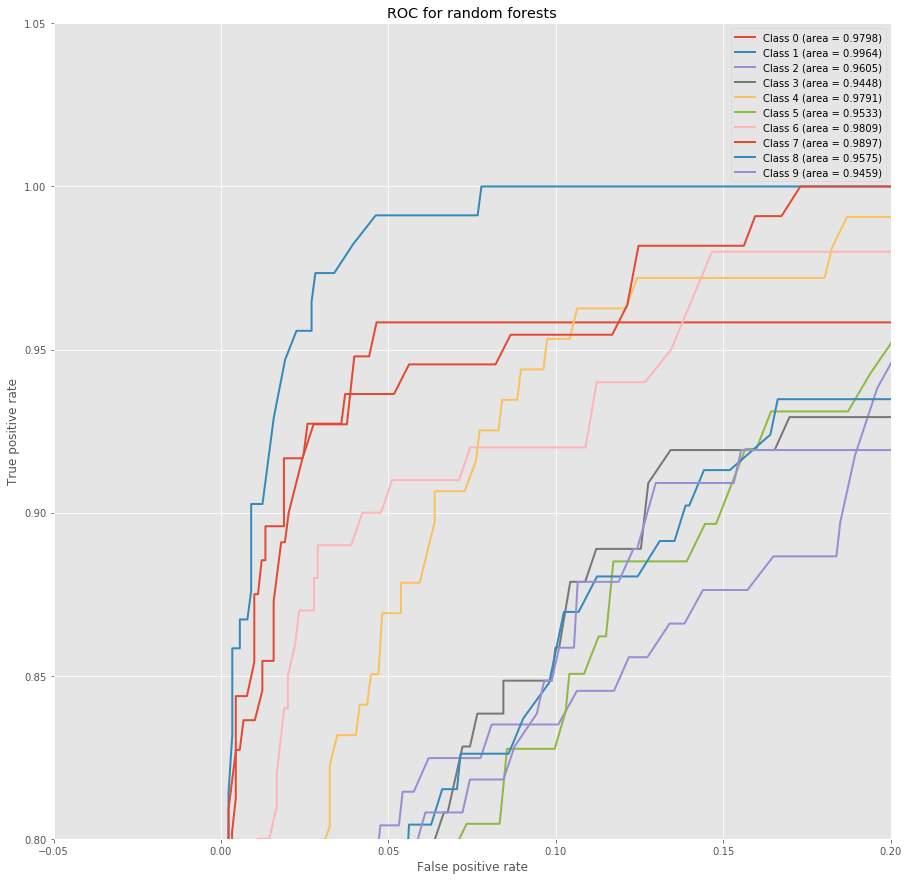

In [31]:
# Visualizing roc & auc for random forests

plt.figure(figsize=(15,15))

for i in classes:
    fpr, tpr, _ = roc_curve(Y[test_index],
                        pl.named_steps['rfc'].predict_proba(X[test_index])[:, i],
                        pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, '-', lw=2, label='Class %s (area = %0.4f)'
               % (i, roc_auc)) 

plt.legend(loc='best')
plt.xlim([-.05, .2])
plt.ylim([0.8, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC for random forests')

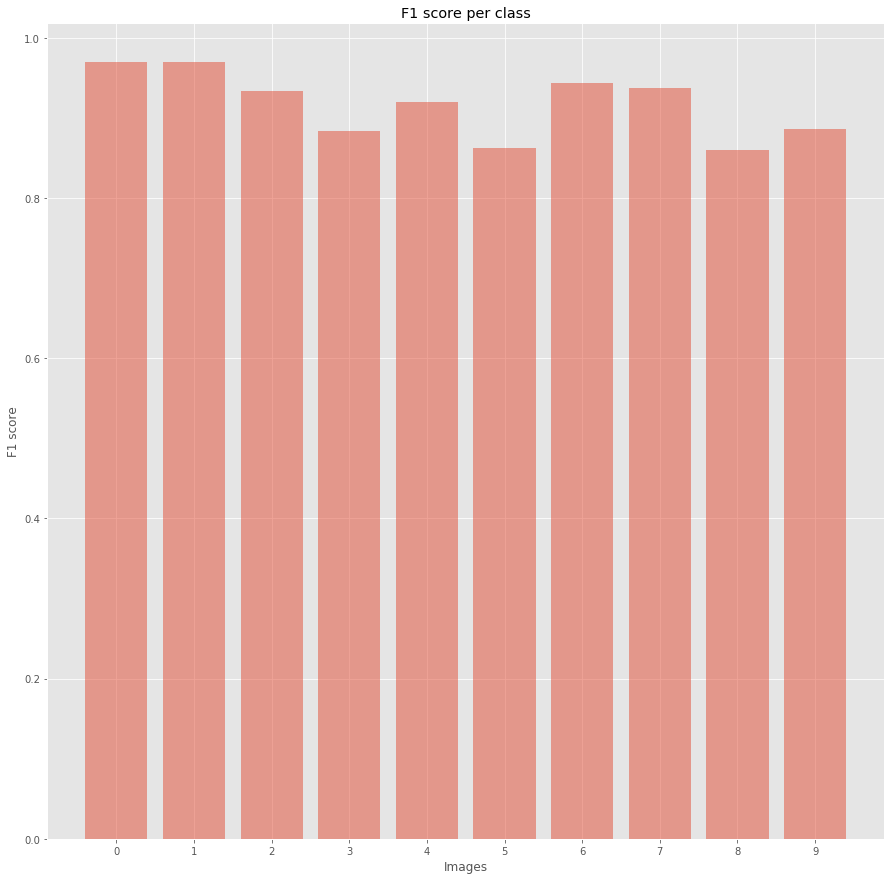

In [32]:
f1_scores = [f1_score(Y[test_index], yhat, average='macro', labels=[j]) for j in classes]
    
plt.figure(figsize=(15,15))

plt.bar(classes, f1_scores, align='center', alpha=0.5)
plt.xticks(classes)

plt.xlabel("Images")
plt.ylabel("F1 score")

plt.title("F1 score per class")
plt.show()

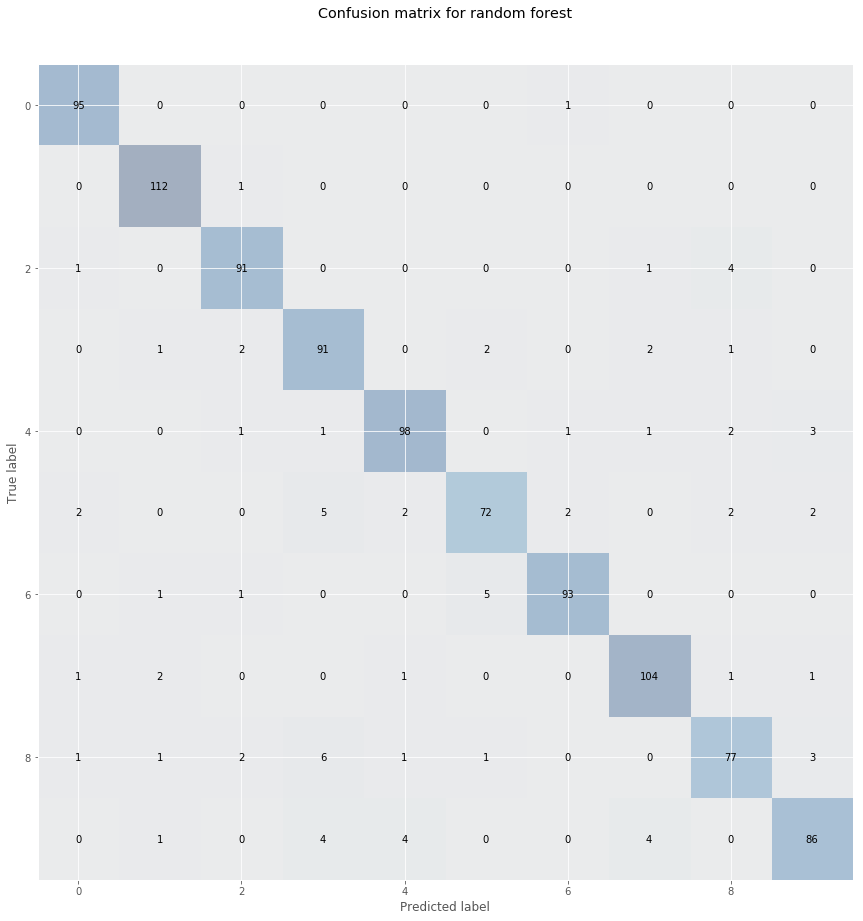

In [33]:
cf_mat = confusion_matrix(Y[test_index], yhat)
fig, ax = plot_confusion_matrix(conf_mat=cf_mat, figsize=(15,15))
plt.title('Confusion matrix for random forest')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()